# HOME CREDIT DEFAULT RISK

# Feature Engineering

Apart from generating important/useful features, it is also critical to remove redundant and noisy features. We need to focus on Data Cleaning and Feature Selection techniques as well. let’s get started.

In [2]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime

import gc
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor


**Defining Utility Functions**

In [2]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

# 1. Feature Selection

In this section, we will try to reduce the number of features, in such a way that it doesn't have a negative impact on the performance of the model.


In [3]:
# loading data
train_data = pd.read_csv("data_preprocessed/train_data.csv", index_col = "SK_ID_CURR")
test_data = pd.read_csv("data_preprocessed/test_data.csv", index_col = "SK_ID_CURR")

In [4]:
# optimize memory usage
train_data, test_data = reduce_mem_usage(train_data), reduce_mem_usage(test_data)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 3835.86 MB
Memory usage after optimization: 1329.94 MB
Decreased by 65.3%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 607.66 MB
Memory usage after optimization: 216.25 MB
Decreased by 64.4%
----------------------------------------------------------------------------------------------------


**Looking for empty features** 

Here, empty features refer to those features which have just one unique value. These features are useless for the classifiers, as they do not contain any information.

In [5]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

There are 0 columns with just 1 unique value
Removing these from dataset


**Recursive Feature Selection using LightGBM**

In this section, we will further try to reduce the feature set, using a Classification Model, using the feature importance attribute . In this method, we will recursively run the Classification model on training dataset, and will check the Cross Validation AUC. If the Cross-Validation AUC goes below a certain threshold, we will stop adding the features the features.

The steps would be:

1. Run the Classifier on whole training set, and calculate 3 fold cross-validation AUC.

2. Select the features which have non-zero feature importance as per the model.

3. Rerun the Classifier with the features which had zero feature importance. This is done because there might be cases where the classifier would have assigned 0-feature imporatnce to some features but that could be due to just that iteration and randomness. So we rerun the classifier on those features, to see if they alone can give good metric score.

4. Stop adding features if the Cross Validation score for low importance features goes below a threshold.

In [6]:
target_train = train_data.pop('TARGET')

In [6]:
class recursive_feature_selector:
    '''
    Class to recursively select top features.
    Contains 2 methods:
        1. init method
        2. main method
    '''
    
    def __init__(self, train_data, test_data, target_train, num_folds = 3, verbose = True, random_state = 5358):
        '''
        Function to initialize the class variables.
        
        Inputs:
            self
            train_data: DataFrame
                Training Data
            test_data: DataFrame
                Test Data
            target_train: Series
                Class Labels for training Data
            num_folds: int, default = 3
                Number of folds for K-Fold CV
            verbose: bool, default = True
                Whether to keep verbosity or not
            random_state: int, default = 5358
                The random state for the classifier for recursive feature selection
                
        Returns: 
            None
        '''
        
        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state
        
    def main(self):
        '''
        Function to select features recursively
        
        Inputs:
            self
        
        Returns:
            Training and testing data with reduced number of features
        '''
        
        if self.verbose:
            print("Starting Feature Selection...")
            start = datetime.now()
            
        #set of important features
        self.important_columns = set()
        score = 1
        i = 1
        
        while score > 0.72:
            if self.verbose:
                print(f"Iteration {i}:")
                
            #removing the features which have been selected from the modelling data
            selection_data = self.train_data.drop(list(self.important_columns), axis = 1)
            #defining the CV strategry
            fold = StratifiedKFold(n_splits = self.num_folds, shuffle = True, random_state = 33)
            #reinitializing the score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)
            
            #doing K-Fold Cross validation
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train),1):
                if self.verbose:
                    print(f"\t\tFitting fold {fold_num}")
                
                #defining the train and validation data
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]
                
                #instantiating the LightGBM Classifier
                lg = LGBMClassifier(n_jobs = -1, random_state = self.random_state)
                lg.fit(x_train, y_train)

                #appending the feature importance of each feature averaged over different folds
                model_feature_importance += lg.feature_importances_ / self.num_folds
                #average k-fold ROC-AUC Score
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:,1]) / self.num_folds

            #getting the non-zero feature importance columns
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            #names of non-zero feature importance columns
            cols_imp = self.train_data.columns[imp_cols_indices]
            
            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNo. of important columns kept = {len(self.important_columns)}")            
            if self.verbose:
                print(f"\tCross Validation score = {score}")
            i += 1
            
        self.important_columns = list(self.important_columns)
        
        if self.verbose:
            print("\nDone Selecting Features.")
            print(f"Total columns removed = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nInitial Shape of train_data = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Final Shape of train_data = {self.train_data.shape}")
            print(f"\nTotal Time Taken = {datetime.now() - start}")
            
        
        gc.collect()
        return self.train_data, self.test_data

In [7]:
import re
train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_data = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) 

In [7]:
#instantiating the class recursive_feature_selector
feature_selector =  recursive_feature_selector(train_data, test_data, target_train)
train_data, test_data = feature_selector.main()
important_columns = feature_selector.important_columns

Starting Feature Selection...
Iteration 1:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1151
	Cross Validation score = 0.797606484649442
Iteration 2:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1246
	Cross Validation score = 0.7130721683527554

Done Selecting Features.
Total columns removed = 363

Initial Shape of train_data = (307507, 1609)
Final Shape of train_data = (307507, 1246)

Total Time Taken = 0:20:59.061676


In [12]:
import pickle

# Store data (serialize)
with open('important_columns.pickle', 'wb') as handle:
    pickle.dump(important_columns, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('important_columns.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

print(important_columns == unserialized_data)

True


In [9]:
import pickle

# Load data (deserialize)
with open('important_columns.pickle', 'rb') as handle:
    important_columns = pickle.load(handle)
    

train_data = train_data[important_columns]
test_data = test_data[important_columns]

In [10]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

# Modelling

Now, we will start the model building.

* We will start with a random model, to create a baseline and thus compare our sensible models with these results.

* Then we will move to Logistic Regression and Linear SVM. We are not using Kernel SVM for high time complexities. The Classifier such as Logistic Regression and Linear Regression really perform well when the data is high dimensional.

* We will then move to ensemble learning models like random forest and Gradient boosting machines.

* Since we are using AUC as our KPI for tuning the models, and it is a case of imbalanced classification, we might have to do threshold tuning for some of the models, which do not give exact probabilities. We will use ROC Curve for threshold moving.

* Lastly, we will do stacking and blending and see if they help to improve the models further.

*Note: We are handling the NaN values by replacing them with 0s only for Sklearn models. The boosting methods like XGBoost, LightGBM inherently handle NaN values as categories, and thus we don't need to explicitly impute any value to them. *

**Random Model**

This model randomly generates a probability value between 0 to 1, for each of the datapoint. This would serve as a baseline model, and that our any sensible model should not perform worse than this.

Training Dataset Results:
	ROC-AUC Score = 0.5030380652625631
	Precision Score = 0.08150431485780804
	Recall Score = 0.5048539778449144
Confusion Matrix of Training data:


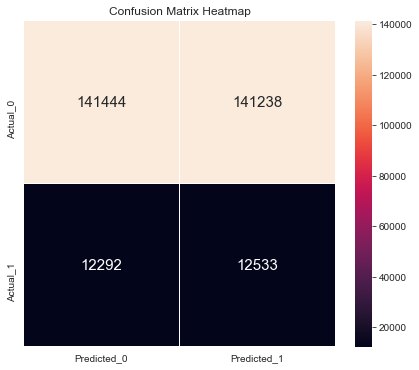

Distribution of Original Class Labels and Predicted Train and Test Class Labels


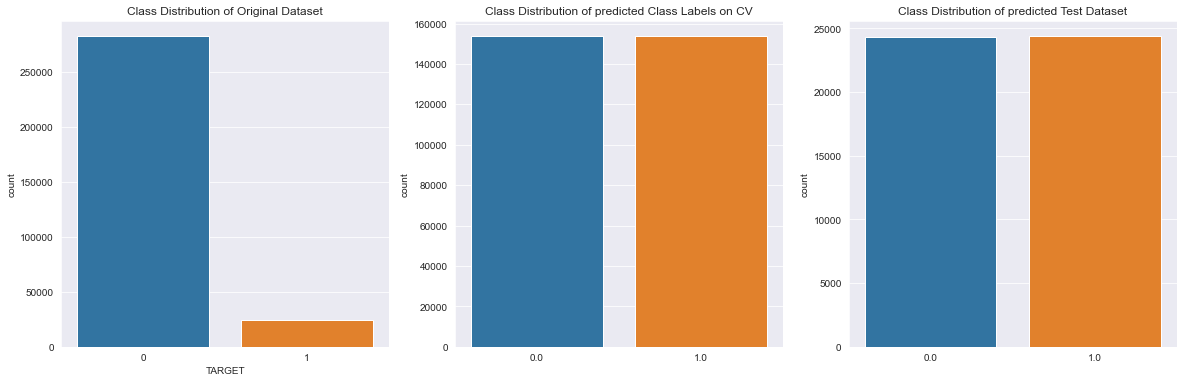

In [11]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 1, len(train_data))
predicted_proba_test = np.random.uniform(0, 1, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

In [29]:
#submitting the result
skid_test = test_data.index
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Random_Model.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Random_Model.csv -m "Random Model Predictions"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default RiskSuccessfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.27M [00:00<?, ?B/s]
  1%|          | 8.00k/1.27M [00:00<00:27, 48.1kB/s]
  7%|6         | 88.0k/1.27M [00:00<00:21, 58.4kB/s]
  8%|8         | 104k/1.27M [00:01<00:17, 68.1kB/s] 
  9%|9         | 120k/1.27M [00:01<00:15, 76.4kB/s]
 10%|#         | 136k/1.27M [00:01<00:14, 82.0kB/s]
 12%|#1        | 152k/1.27M [00:01<00:13, 86.5kB/s]
 13%|#2        | 168k/1.27M [00:01<00:12, 89.9kB/s]
 14%|#4        | 184k/1.27M [00:01<00:12, 91.8kB/s]
 15%|#5        | 200k/1.27M [00:02<00:12, 93.1kB/s]
 17%|#6        | 216k/1.27M [00:02<00:11, 93.6kB/s]
 18%|#7        | 232k/1.27M [00:02<00:11, 94.9kB/s]
 19%|#9        | 248k/1.27M [00:02<00:11, 91.7kB/s]
 20%|##        | 264k/1.27M [00:02<00:11, 94.3kB/s]
 22%|##1       | 280k/1.27M [00:02<00:10, 95.4kB/s]
 23%|##2       | 296k/1.27M [00:03<00:10, 95.6kB/s]
 24%|##4       | 312k/1.27M [00:03<00:16, 60.0kB/s]
 25%|##5       | 328k/1.27M [00:03<00:14, 68.4kB/s]


 26%|##6       | 344k/1.27M [00:03<00:12, 77.1kB/s]
 28%|##7       | 360k/1.27M [00:04<00:11, 82.6kB/s]
 29%|##8       | 376k/1.27M [00:04<00:10, 86.5kB/s]
 30%|###       | 392k/1.27M [00:04<00:10, 89.6kB/s]
 31%|###1      | 408k/1.27M [00:04<00:10, 90.4kB/s]
 33%|###2      | 424k/1.27M [00:04<00:09, 93.4kB/s]
 34%|###3      | 440k/1.27M [00:04<00:09, 95.5kB/s]
 35%|###5      | 456k/1.27M [00:05<00:09, 94.2kB/s]
 36%|###6      | 472k/1.27M [00:05<00:08, 96.9kB/s]
 38%|###7      | 488k/1.27M [00:05<00:08, 95.8kB/s]
 39%|###8      | 504k/1.27M [00:05<00:08, 93.4kB/s]
 40%|####      | 520k/1.27M [00:05<00:08, 94.7kB/s]
 41%|####1     | 536k/1.27M [00:05<00:08, 94.1kB/s]
 43%|####2     | 552k/1.27M [00:06<00:08, 94.9kB/s]
 44%|####3     | 568k/1.27M [00:06<00:11, 63.5kB/s]
 46%|####5     | 592k/1.27M [00:06<00:09, 77.2kB/s]
 47%|####6     | 608k/1.27M [00:06<00:08, 83.5kB/s]
 48%|####8     | 624k/1.27M [00:07<00:08, 86.1kB/s]
 49%|####9     | 640k/1.27M [00:07<00:07, 90.3kB/s]
 51%|##### 

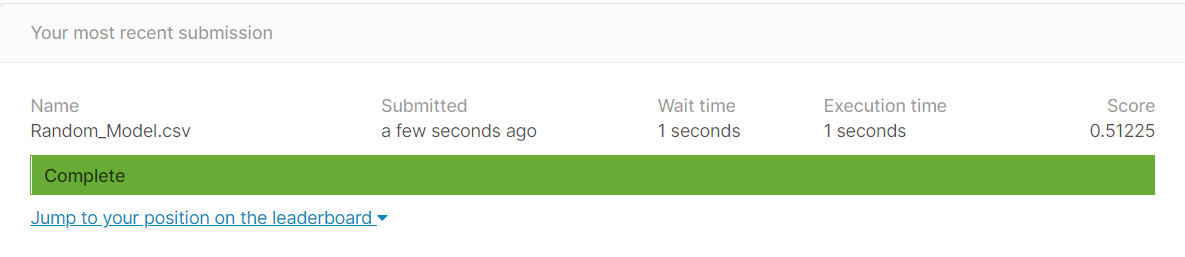 

* From the above Confusion Matrix, we see that it predicts almost equal numbers of Positive and Negative Class Labels. This implies the complete randomness of the model.

* From the Distributions of predicted Class Labels too, we see this behaviour.

* The AUC for the random model on training dataset comes out to be close to 0.5, and the F1-Score close to 0.14.

* The similar AUC is seen from the Test Dataset too, as seen from above submission.

* This sets a baseline for all the metrics here.

**Dominant Class Model** 

* In this model, we will predict everything as the dominant Class, which is Class Label 0 in our case here. We will see the metrics for this model too, and again our sensible models need to perform better than this.

* Since we are calculating the ROC-AUC value as well, so we will randomly predict a probability between 0 to 0.5 with a threshold of 0.5, so that all points get classified as 0.

Training Dataset Results:
	ROC-AUC Score = 0.5001170949136153
	Precision Score = 0.0
	Recall Score = 0.0
Confusion Matrix of Training data:


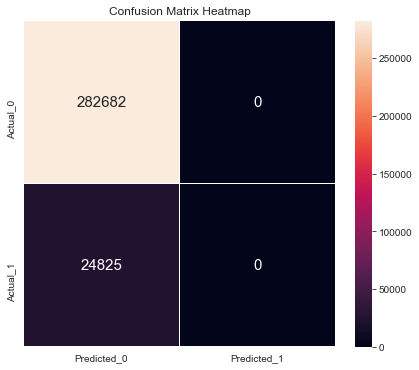

Distribution of Original Class Labels and Predicted Train and Test Class Labels


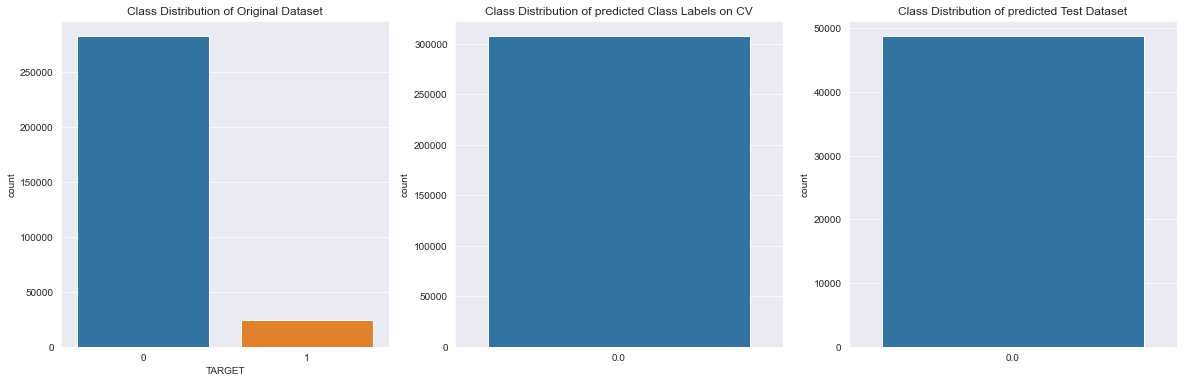

In [12]:
#predicting everything with probability less than 0.5, i.e majority class
predicted_proba_train = np.random.uniform(0, 0.5, len(train_data))
predicted_proba_test = np.random.uniform(0, 0.5, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

In [31]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Dominant_Class_Model.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Dominant_Class_Model.csv -m "Predicted probabilities between 0 to 0.5, with a threshold of 0.5"
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.29M [00:00<?, ?B/s]
  1%|          | 8.00k/1.29M [00:00<00:39, 33.5kB/s]
  7%|6         | 88.0k/1.29M [00:01<00:32, 38.7kB/s]
  7%|7         | 96.0k/1.29M [00:01<00:29, 42.7kB/s]
  8%|7         | 104k/1.29M [00:01<00:28, 43.8kB/s] 
  9%|9         | 120k/1.29M [00:02<00:24, 50.9kB/s]
 10%|#         | 136k/1.29M [00:02<00:19, 60.6kB/s]
 12%|#1        | 152k/1.29M [00:02<00:17, 68.8kB/s]
 13%|#2        | 168k/1.29M [00:02<00:15, 74.5kB/s]
 14%|#3        | 184k/1.29M [00:02<00:14, 79.8kB/s]
 15%|#5        | 200k/1.29M [00:02<00:13, 85.7kB/s]
 16%|#6        | 216k/1.29M [00:03<00:12, 89.6kB/s]
 18%|#7        | 232k/1.29M [00:03<00:12, 91.2kB/s]
 19%|#8        | 248k/1.29M [00:03<00:11, 93.5kB/s]
 20%|##        | 264k/1.29M [00:03<00:11, 95.8kB/s]
 21%|##1       | 280k/1.29M [00:03<00:11, 94.1kB/s]
 22%|##2       | 296k/1.29M [00:03<00:10, 96.5kB/s]
 24%|##3       | 312k/1.29M [00:04<00:10, 95.1kB/s]
 25%|##4       | 328k/1.29M [00:04<00:10, 96.8kB/s]
 26%|##6       

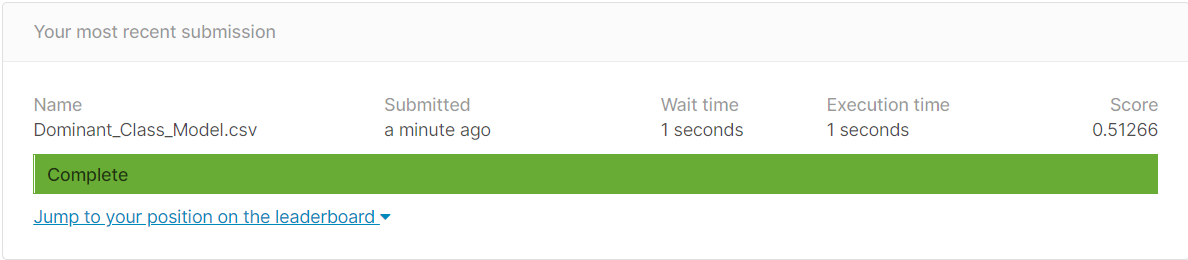

* From the above results, we observe that again the AUC remains somewhat the same, which is 0.5.

* However, the F1-Score is now 0, because we are not predicting anything as a positive class.

* The confusion matrix also shows all points as negative, i.e it has high number of false negtives, but zero false positives.

* The Test AUC is also coherent with training, i.e. 0.5074.

**Logistic Regression L2 Regularization**

* In this section, we will use SGDClassifier with log-loss and l2 penalty. We will use GridSearchCV for Hyperparameter Optimization.

* We haven't split the data into train and cv yet. We will create the cross-validation data on the fly, i.e during hyperparameter tuning.

* For overall predictions on CV, we will use Stratified K-Fold method with predictions as Out-of-fold predictions.

* Since we are optimizing the hyperparameters for AUC and also this is the case of imbalanced dataset, we will tune the threshold for best TPR and least TPR, by using J-Statistic.

In [14]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 982):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 3,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()
        
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            print(train_indices)
            print(val_indices)
            print(self.x_train)
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize = (20,6))
        plt.subplot(1,3,1)
        plt.title('Class Distribution of Original Dataset')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Class Distribution of predicted Class Labels on CV')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Class Distribution of predicted Test Dataset')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 51.1min
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed: 109.5min finished


Done.
Time elapsed = 1:50:10.967777


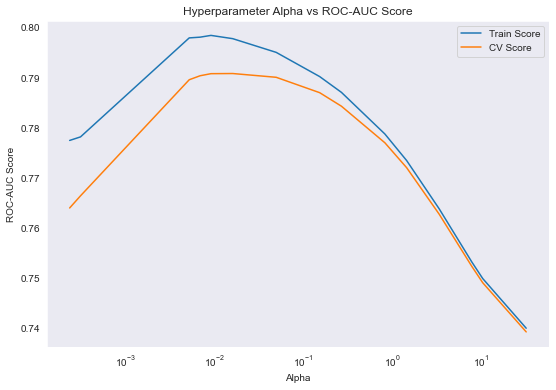

In [15]:
params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 15, n_jobs = 2)

#visualizing the cv results
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

In [16]:
#training on best parameters
sgd_lr_l2.train_on_best_params()
#showing the results
sgd_lr_l2.results_on_best_params('linear')
#plotting feature importances
sgd_lr_l2.feat_importances_show(train_data.columns, num_features = 50)

Fitting Classifier on best parameters

4-Fold Cross Validation
[     1      2      3 ... 307504 307505 307506]
[     0      7     11 ... 307489 307495 307500]
[[ 0.38042963  0.          0.07548028 ... -1.38816188  0.9316751
  -2.06453766]
 [-0.99940439  0.          0.61307313 ...  0.72037708 -0.82264455
  -1.48050075]
 [ 1.42135704  0.          0.5712913  ... -1.38816188  0.
  -2.64857457]
 ...
 [-0.8541587   0.          0.61307313 ...  0.72037708  0.
  -0.31242693]
 [-0.8541587   0.         -0.70026898 ...  0.72037708  0.
   0.85564689]
 [-0.99940439  0.          0.24678577 ...  0.72037708 -0.0660168
  -0.31242693]]
	Fitting Fold 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').